In [ ]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import os
import sys

from torch.utils.data import Dataset, DataLoader

from ultralytics import YOLO

from data.dataset import BoundingBoxDataset, MODEL_PATH, inspect_dataloader
from data_synthesise.data_synthesiser import SyntheticDataset

import sys
import io

In [3]:
model = YOLO(MODEL_PATH)
sequence_length = 20
data_path = '/root/aifr/wdwyl_ros1/videos'
train_data_path = os.path.join(data_path, 'train')
val_data_path = os.path.join(data_path, 'val')

batch_size = 1

# Use real dataset
# train_dataset = BoundingBoxDataset(train_data_path, yolo_model=model, sequence_length=sequence_length, 
#                                    default_seq_label='train_default_sequence_label')
# val_dataset = BoundingBoxDataset(val_data_path, yolo_model=model, sequence_length=sequence_length, 
#                                  default_seq_label='val_default_sequence_label')

# Use synthesised dataset
num_synthesised_samples = 1000
train_val_ratio = 0.8
num_train_samples = int(num_synthesised_samples * train_val_ratio)
num_val_samples = num_synthesised_samples - num_train_samples

train_dataset = SyntheticDataset(sequence_length, num_train_samples)
val_dataset = SyntheticDataset(sequence_length,num_val_samples)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Synthetic data does not exist. Generate...
this data:  [          0           0           0           0           0           1           0           0           1           0           0           0           0           1           1           0           0           0           0           0]
this data:  [          0           0           0           0           0           0           0           0           0           0           1           0           0           0           0           0           0           0           0           0]
this data:  [          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           0           1           0           0]
this data:  [          0           0           0           0           0           0           0           0           0           0           0           0           0           0           0   

In [ ]:
# inspect_dataloader(train_loader)

In [ ]:
# inspect_dataloader(val_loader)

In [ ]:
# print(train_dataset.sequences)

In [3]:
train_dataset.get_all_videos_full_sequence()

In [ ]:
train_dataset.get_all_videos_full_sequence()

In [4]:
import torch
import torch.optim as optim
import torch.nn as nn

class BinaryLSTM(nn.Module):
    """
    input and output tensors are of shape [batch, seq, feature]
    """

    def __init__(self, input_size=1, output_size=1, hidden_size=50, num_layers=1):
        super().__init__()

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_hidden_state = lstm_out[:, -1, :]
        output = self.fc(last_hidden_state)
        output = output.squeeze(-1)

        return output

LSTM_input_size = 1 # Each time step, a specific bounding box appears (1) or not (0) 
device = 'cuda:0'

LSTM_model = BinaryLSTM(LSTM_input_size).to(device)
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss() #nn.MSELoss()

In [8]:
save_path = '/root/aifr/wdwyl_ros1/perception/lstm/runs/lstm_model.pth'
epochs = 40
training_loss = []
testing_loss = []
for epoch in range(epochs):
    for X_batch, y_batch in train_loader:

        # print("x_batch shape: ", X_batch.shape)

        LSTM_model.train()
        
        X_batch = X_batch.view(X_batch.size(0), X_batch.size(1), 1)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # print("y_batch shape: ", y_batch.shape)


        # pass through the LSTM model
        outputs = LSTM_model(X_batch)
        # print("outputs shape: ", outputs.shape)

        # loss function (remember the LSTM output and the y_batch must have the same shape)
        loss = loss_fn(outputs, y_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # raise RuntimeError("stop here")

    # testing
    if epoch % 10 == 0:
        with torch.no_grad():

            # compute the loss function for the training set
            total_loss = 0
            number_of_batches = 0
            for X_batch, y_batch in train_loader:

                LSTM_model.eval()

                X_batch = X_batch.view(X_batch.size(0), X_batch.size(1), 1)
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # pass through the LSTM model
                outputs = LSTM_model(X_batch)

                # loss function
                loss = loss_fn(outputs, y_batch)

                total_loss += loss.item() # loss.item() returns the loss value as a float (free of the gradient)
                number_of_batches += 1

            training_loss.append(total_loss/number_of_batches)

            # compute the loss function for the testing set
            total_loss = 0
            number_of_batches = 0
            for X_batch, y_batch in val_loader:

                LSTM_model.eval()
                
                X_batch = X_batch.view(X_batch.size(0), X_batch.size(1), 1)
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                # pass through the LSTM model
                outputs = LSTM_model(X_batch)

                # loss function
                loss = loss_fn(outputs, y_batch)

                total_loss += loss.item()
                number_of_batches += 1

            testing_loss.append(total_loss/number_of_batches)

        # print the loss
        print('Epoch: ', epoch, '\tTraining loss: ', '% 6.2f' % training_loss[-1], '\tTesting loss: ', '% 6.2f' % testing_loss[-1])

    # Save the model checkpoint
    # torch.save(LSTM_model.state_dict(), f'runs/lstm_model_epoch_{epoch}.pth')

# Save the final model
torch.save(LSTM_model.state_dict(), save_path)
print(f'Model saved to {save_path}')

Epoch:  0 	Training loss:    0.00 	Testing loss:    0.00
Epoch:  10 	Training loss:    0.00 	Testing loss:    0.00
Epoch:  20 	Training loss:    0.00 	Testing loss:    0.00
Epoch:  30 	Training loss:    0.00 	Testing loss:    0.00
Model saved to /root/aifr/wdwyl_ros1/perception/lstm/runs/lstm_model.pth


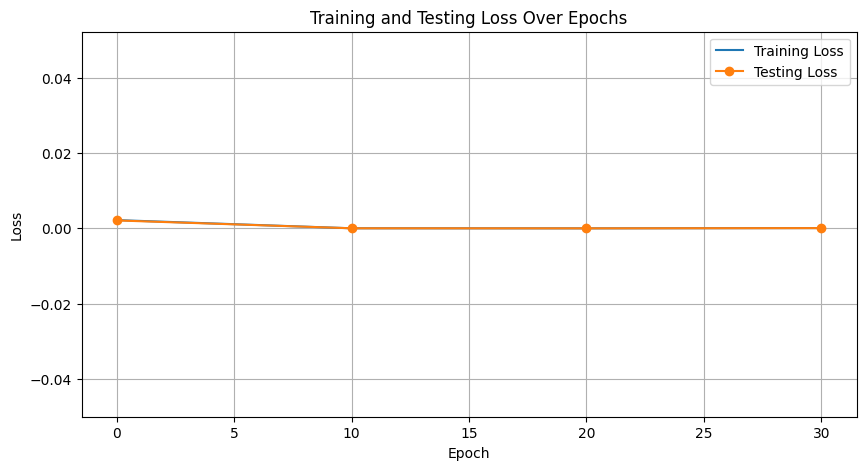

In [6]:
import matplotlib.pyplot as plt

# plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(0, 40, 10), training_loss, label='Training Loss')
plt.plot(range(0, 40, 10), testing_loss, label='Testing Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(min(min(training_loss), min(testing_loss)) -0.05, max(max(training_loss), max(testing_loss)) + 0.05)

plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()